## 1. zadatak 

- Koristiti fajl `bhm.npy` koji sadrži **mase crnih rupa** (u masama Sunca)  
- Izračunati:
  - **standardnu devijaciju**
  - **medijanu**
  - **koeficijent asimetrije**
- Procijeniti **neodređenosti** u ove tri statistike koristeći:
  - **a)** Bootstrap metodu (sa 10.000 reuzoraka)
  - **b)** Jackknife metodu (izbacivanje po dva podatka, *leave two out*)
- **Zašto je za izvršavanje Jackknife metode potrebno značajno više vremena?**
- **Uporediti rezultate vizuelno** i zaključiti **koja metoda daje pouzdaniju procjenu** (za svaku statistiku posebno)
- **Ubaciti deset ekstremnih vrijednosti** ($MBH = 1000 M_\odot$) u podatke i zaključiti **kako to utiče** na sve gore navedeno

---

Crne rupe se mogu formirati na različite načine (**kanali formiranja**) i klasifikuju se u populacije.  
Pretpostavljamo da svaka populacija ima **Gausovsku raspodjelu**, a da je ukupna raspodjela mješavina više Gaussovskih:

$$
p(m) = \sum_{j=1}^{N} \alpha_j \cdot \mathcal{N}(m \mid \mu_j, \sigma_j), \quad \sum_{j=1}^{N} \alpha_j = 1
$$

- Na osnovu **plota raspodjele masa crnih rupa**, naći **najviše pikove**  
- Koristiti `sklearn.mixture.GaussianMixture` za fitovanje modela za različit broj komponenti ($N = 1, 2, ..., 10$)  
- Za svaku vrijednost $N$ utvrditi:
  - **težinske faktore** $\alpha_j$
  - **prosječne mase** $\mu_j$
  - **standardne devijacije** $\sigma_j$  
- **Plotovati histograme pojedinačnih Gaussovskih komponenti** koje predstavljaju dobijene raspodjele  
- **Ispitati stabilnost dobijenih parametara u zavisnosti od broja komponenti** i objasniti šta to ukazuje o **mogućim kanalima formiranja crnih rupa**


In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import skew
from sklearn.mixture import GaussianMixture
from tqdm import tqdm
from scipy.signal import find_peaks

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="joblib")


## 1. Učitavanje podataka

In [4]:
masses_original = np.load("bhm.npy").flatten()

##  Uzimanje tačno 10.000 podataka uz ponavljanje

In [8]:
np.random.seed(42)
masses = np.random.choice(masses_original, size=10000, replace=True)


## 2. Osnovne statistike

In [11]:
std_dev = np.std(masses, ddof=1)
median = np.median(masses)
skewness = skew(masses)

## 3. BOOTSTRAP procjena

In [15]:
n_boot = 10000
boot_samples = np.random.choice(masses, size=(n_boot, len(masses)), replace=True)

boot_std = np.std(boot_samples, axis=1, ddof=1)
boot_median = np.median(boot_samples, axis=1)
boot_skew = np.array([skew(sample) for sample in boot_samples])

boot_std_err = np.std(boot_std)
boot_median_err = np.std(boot_median)
boot_skew_err = np.std(boot_skew)

## 4. Jackknife

In [18]:
def jackknife_random_leave_two_out(data, func, K=10000):
    n = len(data)
    rng = np.random.default_rng(0)
    estimates = []

    for _ in tqdm(range(K), desc=f"Jackknife L2O (random) {func.__name__}"):
        i, j = rng.choice(n, size=2, replace=False)
        sample = np.delete(data, [i, j])
        estimates.append(func(sample))

    estimates = np.array(estimates)
    mean_est = np.mean(estimates)
    std_err = np.sqrt((4 / K) * np.sum((estimates - mean_est)**2))

    return mean_est, std_err, estimates

# Pozivi funkcije
jk_std_mean, jk_std_err, jk_std_raw = jackknife_random_leave_two_out(masses, lambda x: np.std(x, ddof=1))
jk_median_mean, jk_median_err, jk_median_raw = jackknife_random_leave_two_out(masses, np.median)
jk_skew_mean, jk_skew_err, jk_skew_raw = jackknife_random_leave_two_out(masses, skew)

Jackknife L2O (random) skew: 100%|██████████| 10000/10000 [00:07<00:00, 1322.02it/s]


## 5. Formiranje tabelarnih rezultata

In [22]:
df = pd.DataFrame({
    'Statistika': ['Standardna devijacija', 'Medijana', 'Asimetrija'],
    'Vrijednost': [std_dev, median, skewness],
    'Bootstrap ±': [boot_std_err, boot_median_err, boot_skew_err],
    'Jackknife ±': [jk_std_err, jk_median_err, jk_skew_err]
})

print("\nREZULTATI (10,000 podataka):\n")
print(df.to_string(index=False))


REZULTATI (10,000 podataka):

           Statistika  Vrijednost  Bootstrap ±  Jackknife ±
Standardna devijacija    7.066748     0.046463     0.001284
             Medijana   26.517859     0.119159     0.000617
           Asimetrija   -0.182896     0.023416     0.000627


## 6. Uticaj ekstremnih vrijednosti

In [25]:
masses_ext = np.concatenate([masses, np.ones(10) * 1000])
std_ext = np.std(masses_ext, ddof=1)
median_ext = np.median(masses_ext)
skew_ext = skew(masses_ext)

print("\nEfekat ekstremnih vrijednosti:")
print(f"- Std: {std_ext:.2f} (original: {std_dev:.2f})")
print(f"- Median: {median_ext:.2f} (original: {median:.2f})")
print(f"- Skewness: {skew_ext:.2f} (original: {skewness:.2f})")


Efekat ekstremnih vrijednosti:
- Std: 31.57 (original: 7.07)
- Median: 26.52 (original: 26.52)
- Skewness: 29.24 (original: -0.18)


Najviši pikovi u raspodjeli masa crnih rupa:
Pik 1: masa = 14.31 M_sun, gustina = 0.0111
Pik 2: masa = 20.23 M_sun, gustina = 0.0942
Pik 3: masa = 25.36 M_sun, gustina = 0.0427
Pik 4: masa = 28.66 M_sun, gustina = 0.0542
Pik 5: masa = 31.75 M_sun, gustina = 0.0595


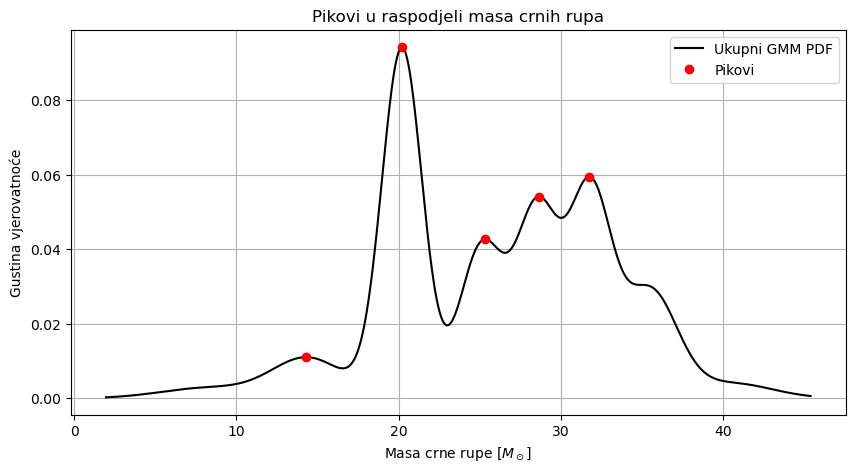

In [49]:
# Računam ukupni GMM PDF 
x_vals = np.linspace(min(masses), max(masses), 1000)
pdf = np.zeros_like(x_vals)

# Sabiram doprinose svake komponente
for w, mu, sigma in zip(best_model.weights_, best_model.means_.flatten(), np.sqrt(best_model.covariances_).flatten()):
    comp_pdf = w * (1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-(x_vals - mu)**2 / (2 * sigma**2))
    pdf += comp_pdf

# Pronalazak pikova u PDF funkciji
peaks, _ = find_peaks(pdf, height=0)

# Ispis rezultata
print("Najviši pikovi u raspodjeli masa crnih rupa:")
for i, idx in enumerate(peaks):
    print(f"Pik {i+1}: masa = {x_vals[idx]:.2f} M_sun, gustina = {pdf[idx]:.4f}")

# Vizuelizacija sa označenim pikovima
plt.figure(figsize=(10, 5))
plt.plot(x_vals, pdf, label='Ukupni GMM PDF', color='black')
plt.plot(x_vals[peaks], pdf[peaks], "ro", label="Pikovi")
plt.xlabel(r"Masa crne rupe [$M_\odot$]")
plt.ylabel("Gustina vjerovatnoće")
plt.title("Pikovi u raspodjeli masa crnih rupa")
plt.legend()
plt.grid(True)
plt.show()


## 7. Gaussian Mixture model

C:\Users\Tatjana\anaconda\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\Tatjana\anaconda\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\Tatjana\anaconda\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Tatjana\anaconda\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\Tatjana\anaconda\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.Crea

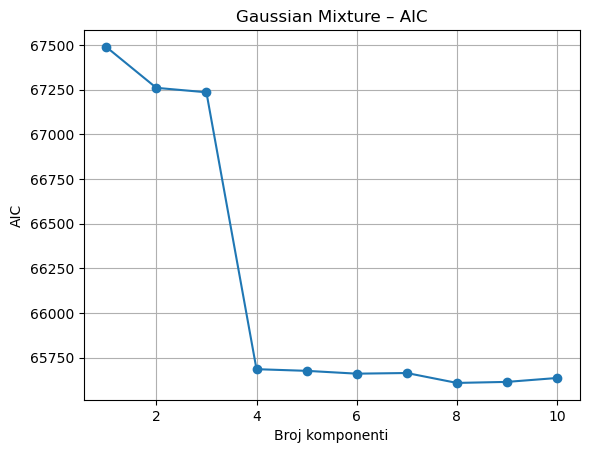

In [30]:
X = masses.reshape(-1, 1)
aics = []
n_components_range = range(1, 11)
models = []

for n in n_components_range:
    gmm = GaussianMixture(n_components=n, random_state=42)
    gmm.fit(X)
    aics.append(gmm.aic(X))
    models.append(gmm)

# Prikaz AIC
plt.figure()
plt.plot(n_components_range, aics, marker='o')
plt.xlabel("Broj komponenti")
plt.ylabel("AIC")
plt.title("Gaussian Mixture – AIC")
plt.grid(True)
plt.show()

## 8. Najbolji model i plotovi


Najbolji broj komponenti (AIC): 8


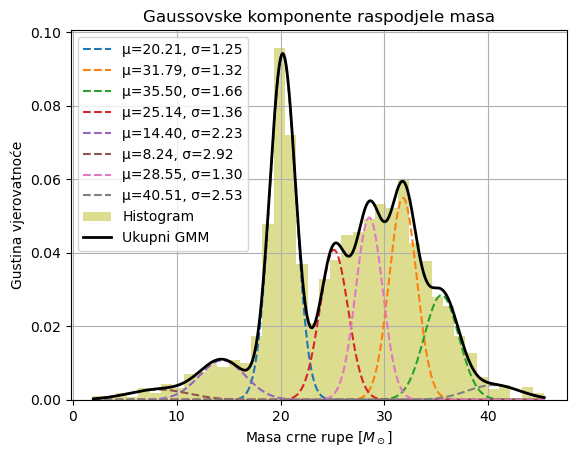

In [51]:
best_index = np.argmin(aics)
best_model = models[best_index]
print(f"\nNajbolji broj komponenti (AIC): {n_components_range[best_index]}")

x_vals = np.linspace(min(masses), max(masses), 1000)
pdf = np.zeros_like(x_vals)

plt.figure()
for w, mu, sigma in zip(best_model.weights_, best_model.means_.flatten(), np.sqrt(best_model.covariances_).flatten()):
    comp_pdf = w * (1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-(x_vals - mu)**2 / (2 * sigma**2))
    pdf += comp_pdf
    plt.plot(x_vals, comp_pdf, linestyle='--', label=f"μ={mu:.2f}, σ={sigma:.2f}")

plt.hist(masses, bins=40, density=True, alpha=0.5, label="Histogram")
plt.plot(x_vals, pdf, color='black', linewidth=2, label="Ukupni GMM")
plt.legend()
plt.title("Gaussovske komponente raspodjele masa")
plt.xlabel(r"Masa crne rupe [$M_\odot$]")
plt.ylabel("Gustina vjerovatnoće")
plt.grid(True)
plt.show()

In [35]:
# Priprema tabele sa svim GMM parametrima
rows = []

for n, model in zip(n_components_range, models):
    weights = model.weights_
    means = model.means_.flatten()
    stds = np.sqrt(model.covariances_).flatten()
    
    for j in range(n):
        rows.append({
            "Broj komponenti (N)": n,
            "Komponenta #": j + 1,
            "αⱼ (težinski faktor)": weights[j],
            "μⱼ (srednja masa)": means[j],
            "σⱼ (standardna devijacija)": stds[j]
        })

df_gmm = pd.DataFrame(rows)
pd.set_option("display.precision", 4)  # za ljepši prikaz
display(df_gmm)


,Broj komponenti (N),Komponenta #,αⱼ (težinski faktor),μⱼ (srednja masa),σⱼ (standardna devijacija)
0,1,1,1.0000,26.0877,7.0664
1,2,1,0.4823,20.5081,4.7926
2,2,2,0.5177,31.2847,4.3639
3,3,1,0.5079,20.6441,4.7591
4,3,2,0.2238,29.4519,2.8163
5,3,3,0.2683,33.5848,3.8576
6,4,1,0.2638,20.1780,1.1988
7,4,2,0.3805,28.0147,3.4282
8,4,3,0.2619,33.6096,3.8827
9,4,4,0.0938,13.8941,4.3094


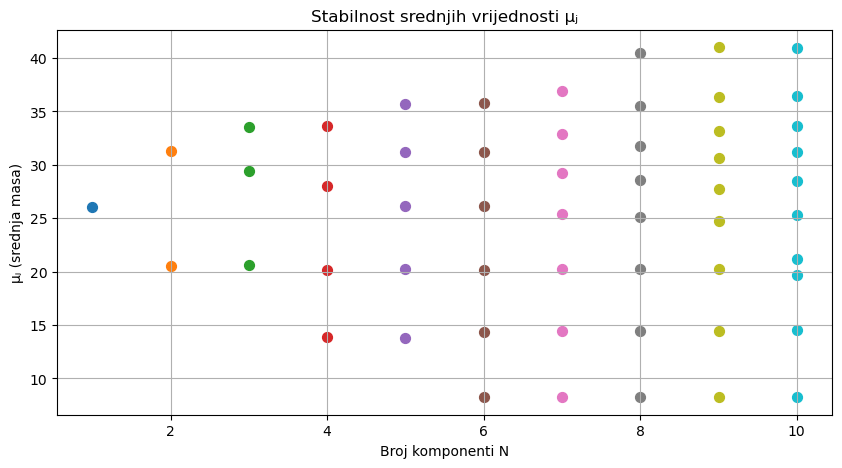

In [37]:
plt.figure(figsize=(10, 5))
for n, model in zip(n_components_range, models):
    mus = model.means_.flatten()
    plt.scatter([n]*len(mus), mus, label=f"N={n}" if n <= 5 else "", s=50)

plt.xlabel("Broj komponenti N")
plt.ylabel("μⱼ (srednja masa)")
plt.title("Stabilnost srednjih vrijednosti μⱼ")
plt.grid(True)
plt.show()


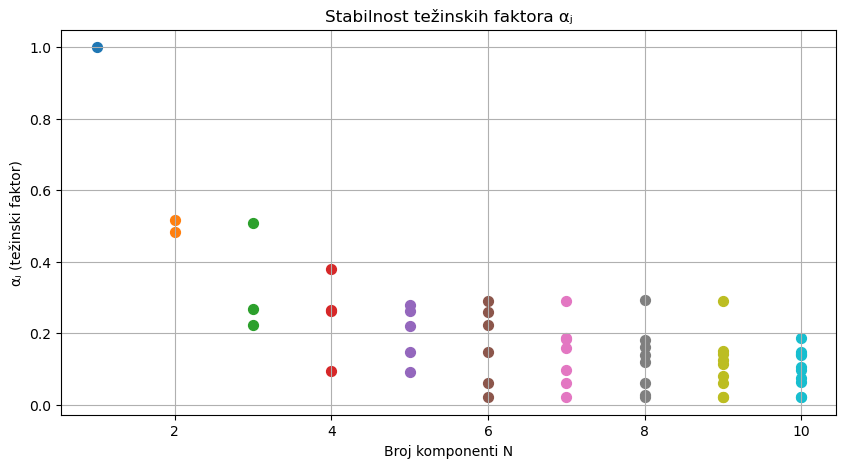

In [39]:
plt.figure(figsize=(10, 5))
for n, model in zip(n_components_range, models):
    alphas = model.weights_.flatten()
    plt.scatter([n]*len(alphas), alphas, s=50)

plt.xlabel("Broj komponenti N")
plt.ylabel("αⱼ (težinski faktor)")
plt.title("Stabilnost težinskih faktora αⱼ")
plt.grid(True)
plt.show()


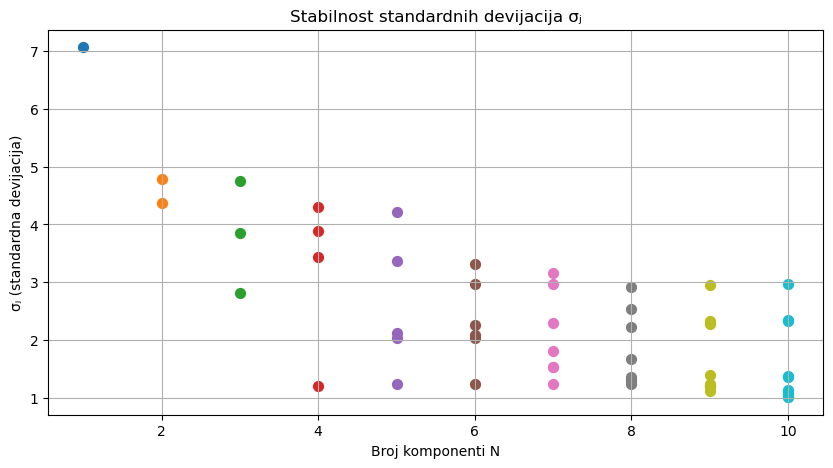

In [41]:
plt.figure(figsize=(10, 5))
for n, model in zip(n_components_range, models):
    sigmas = np.sqrt(model.covariances_).flatten()
    plt.scatter([n]*len(sigmas), sigmas, s=50)

plt.xlabel("Broj komponenti N")
plt.ylabel("σⱼ (standardna devijacija)")
plt.title("Stabilnost standardnih devijacija σⱼ")
plt.grid(True)
plt.show()
